In [105]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from datetime import datetime

np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

n_epochs = 1   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 200    # Size of the train dataset
n_test = 120     # Size of the test dataset
n_batches = 1     # Size of the batches

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]




In [106]:
# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

n_qubits = 4
dev = qml.device("default.qubit.tf", wires=n_qubits)

@qml.qnode(dev, interface='tf')
def qnotnode(inputs):
    inputs *= np.pi
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
    return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

In [107]:
operation = []

for j in range(0, 28, 2):
    for k in range(0, 28, 2):
        operation.append(
            [
                [j, k, 0],
                [j, k + 1, 0],
                [j + 1, k, 0],
                [j + 1, k + 1, 0]
            ]
        )

operations = tf.convert_to_tensor(np.asarray(operation))


@tf.function(input_signature=(tf.TensorSpec(shape=[4, 3], dtype=tf.int64), tf.TensorSpec(shape=[28,28,1], dtype=tf.float32),))
def ops(op, subject):      
  qnode_inputs = []
  qnode_inputs = tf.gather_nd(subject,op)
  return tf.dtypes.cast(qnotnode(qnode_inputs), tf.float32)


@tf.function(input_signature=(tf.TensorSpec(shape=[28, 28, 1], dtype=tf.float32),))
def squares(inputs):
  return tf.reshape(
     tf.map_fn(lambda x: ops(x, inputs), 
                    operations,
                    parallel_iterations=196,
                    fn_output_signature=tf.TensorSpec(shape=[4,], dtype=tf.float32)
                    ),
      [14,14,4])

@tf.function(input_signature=(tf.TensorSpec(shape=[4,28,28,1], dtype=tf.float32),))
def batches(data):
  return tf.map_fn(lambda x: squares(x), 
                   data,
                    parallel_iterations=4,
                    fn_output_signature=tf.TensorSpec(shape=[14,14, 4], dtype=tf.float32)
                    )

ex = lambda im: batches(im)

In [108]:
ou = ex(train_images[:4])

In [109]:
ou.shape

TensorShape([4, 14, 14, 4])

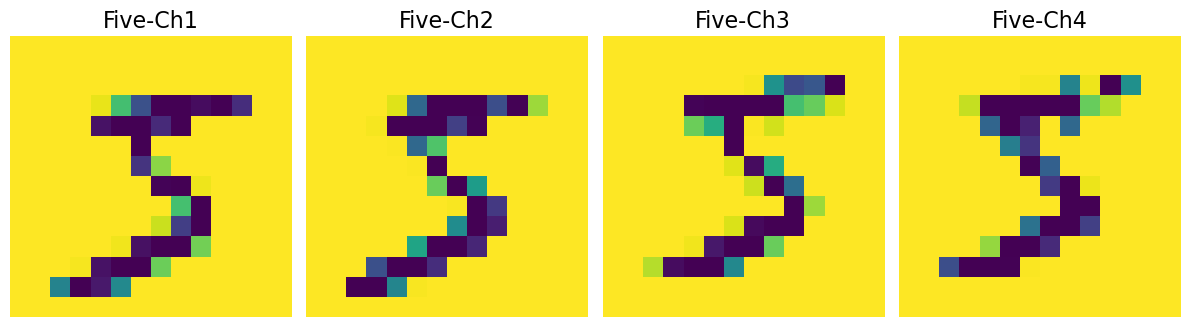

In [110]:
image_titles = ['Five-Ch1', 'Five-Ch2', 'Five-Ch3','Five-Ch4']
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(ou[0,:,:,i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()